In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append("../code/.")
from plotting_functions import *
from utils import *

pd.set_option("display.max_colwidth", 200)

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### Announcements

- Homework 3 is due on Monday, Oct 2nd.
- Worksheet 1 and 2 grades have been released.
- Homework 2 grading is almost done. The grades will be released later today. 

## Preprocessing mistakes

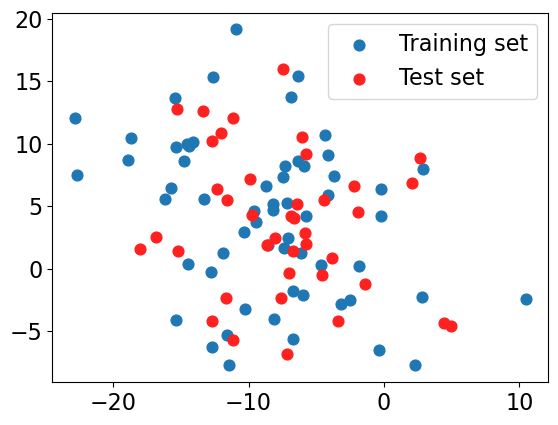

In [2]:
from sklearn.datasets import make_blobs, make_classification
# make synthetic data
X, y = make_blobs(n_samples=100, centers=3, random_state=12, cluster_std=5)
# split it into training and test sets
X_train_toy, X_test_toy, y_train_toy, y_test_toy = train_test_split(
    X, y, random_state=5, test_size=0.4)
plt.scatter(X_train_toy[:, 0], X_train_toy[:, 1], label="Training set", s=60)
plt.scatter(
    X_test_toy[:, 0], X_test_toy[:, 1], color=mglearn.cm2(1), label="Test set", s=60
)
plt.legend(loc="upper right")

#### Bad methodology 1: Scaling the data separately (for class discussion)

In [3]:
# DO NOT DO THIS! For illustration purposes only.
scaler = StandardScaler()
scaler.fit(X_train_toy)
train_scaled = scaler.transform(X_train_toy)

scaler = StandardScaler()  # Creating a separate object for scaling test data
scaler.fit(X_test_toy)  # Calling fit on the test data
test_scaled = scaler.transform(
    X_test_toy
)  # Transforming the test data using the scaler fit on test data

knn = KNeighborsClassifier()
knn.fit(train_scaled, y_train_toy)
print(f"Training score: {knn.score(train_scaled, y_train_toy):.2f}")
print(f"Test score: {knn.score(test_scaled, y_test_toy):.2f}")

Training score: 0.63
Test score: 0.60


In [ ]:
plot_original_scaled(
    X_train_toy,
    X_test_toy,
    train_scaled,
    test_scaled,
    title_transformed="Improperly transformed",
)

#### Bad methodology 2: Scaling the data together (for class discussion)

In [4]:
# join the train and test sets back together
XX = np.vstack((X_train_toy, X_test_toy))
XX.shape

(100, 2)

In [6]:
scaler = StandardScaler()
scaler.fit(XX)
XX_scaled = scaler.transform(XX)
XX_train = XX_scaled[:X_train_toy.shape[0]]
XX_test = XX_scaled[X_train_toy.shape[0]:]

In [8]:
knn = KNeighborsClassifier()
knn.fit(XX_train, y_train_toy)
print(f"Training score: {knn.score(XX_train, y_train_toy):.2f}")  # Misleading score
print(f"Test score: {knn.score(XX_test, y_test_toy):.2f}")  # Misleading score

Training score: 0.63
Test score: 0.55


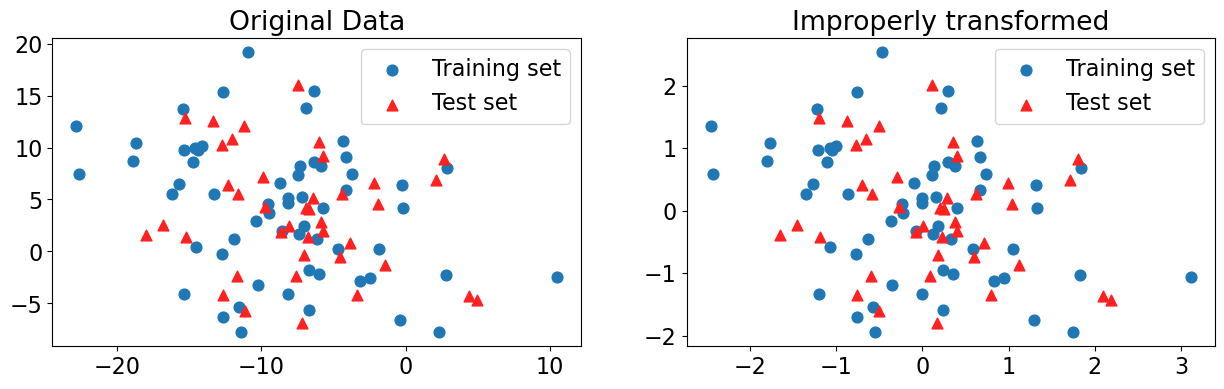

In [9]:
plot_original_scaled(
    X_train_toy,
    X_test_toy,
    XX_train,
    XX_test,
    title_transformed="Improperly transformed",
)

In [10]:
XX_scaled[:, 0].mean(), XX_scaled[:, 0].std(), 

(-5.218048215738236e-16, 1.0)

In [11]:
XX_train[:, 0].mean(), XX_train[:, 0].std()

(-0.07799695717181604, 1.0501997049901186)

In [12]:
XX_test[:, 0].mean(), XX_test[:, 0].std()

(0.11699543575772282, 0.9070874541507946)

#### Bad methodology 3: Cross validation with already preprocessed data (for class discussion)

In [13]:
knn = KNeighborsClassifier()

scaler = StandardScaler()
scaler.fit(X_train_toy)
X_train_scaled = scaler.transform(X_train_toy)
X_test_scaled = scaler.transform(X_test_toy)
scores = cross_validate(knn, X_train_scaled, y_train_toy, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001127,0.004197,0.250000,0.687500
1,0.000703,0.001908,0.500000,0.625000
2,0.000761,0.001994,0.583333,0.541667
3,0.000438,0.001536,0.583333,0.604167
4,0.000413,0.001554,0.416667,0.604167


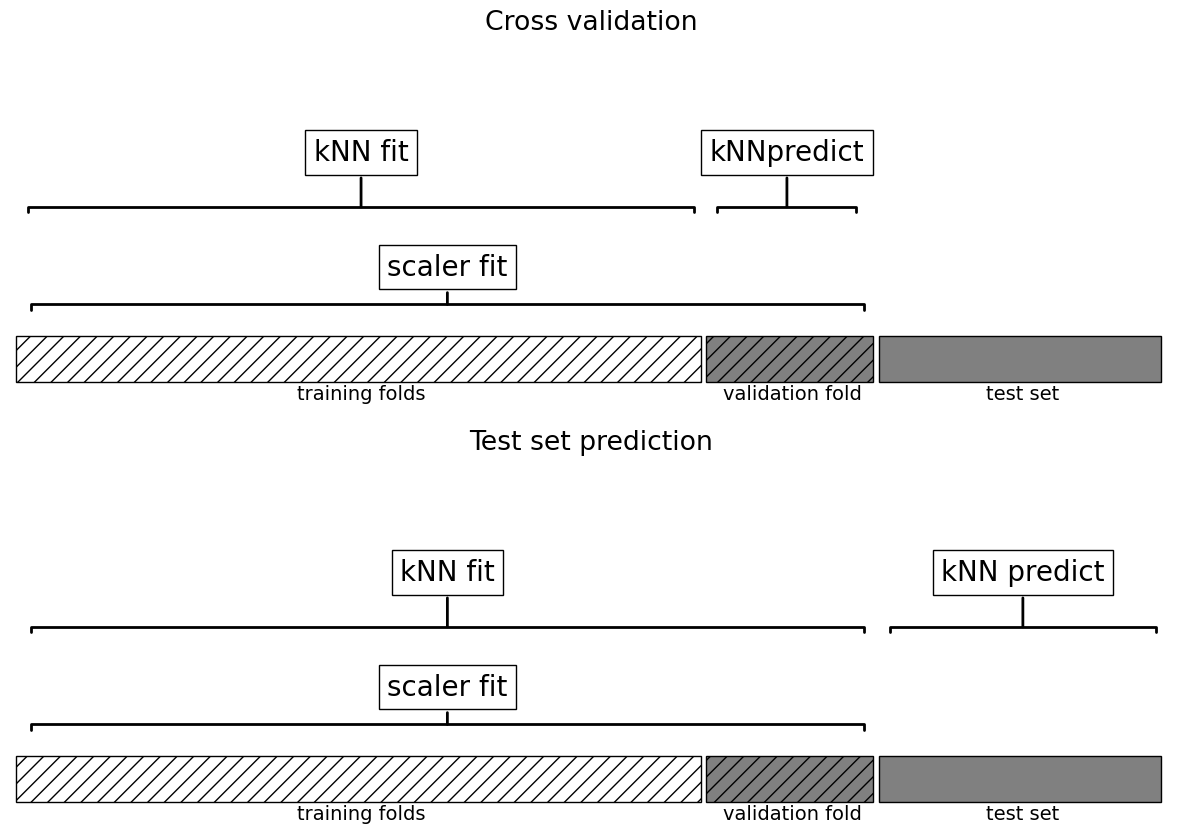

In [14]:
plot_improper_processing("kNN")

### (iClicker) Exercise 5.3

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

1. You can have scaling of numeric features, one-hot encoding of categorical features, and `scikit-learn` estimator within a single pipeline.  
2. Once you have a `scikit-learn` pipeline object with an estimator as the last step, you can call `fit`, `predict`, and `score` on it.
3. You can carry out data splitting within `scikit-learn` pipeline. 
4. We have to be careful of the order we put each transformation and model in a pipeline.
5. If you call `cross_validate` with a pipeline object, it will call `fit` and `transform` on the training fold and only `transform` on the validation fold. 

### Learning outcomes 

From this lecture, you will be able to 

- Use `ColumnTransformer` to build all our transformations together into one object and use it with `sklearn` pipelines.
- Define `ColumnTransformer` where transformers contain more than one steps.
- Explain `handle_unknown="ignore"` hyperparameter of `scikit-learn`'s `OneHotEncoder`.
- Explain `drop="if_binary"` argument of `OneHotEncoder`;
- Identify when it's appropriate to apply ordinal encoding vs one-hot encoding.
- Explain strategies to deal with categorical variables with too many categories. 
- Explain why text data needs a different treatment than categorical variables.
- Use `scikit-learn`'s `CountVectorizer` to encode text data.
- Explain different hyperparameters of `CountVectorizer`.
- Incorporate text features in a machine learning pipeline.

### sklearn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

In [ ]:
df = pd.read_csv("../data/quiz2-grade-toy-col-transformer.csv")
df.head()

In [ ]:
df.info()

In [ ]:
X = df.drop(columns=["quiz2"])
y = df["quiz2"]
X.columns

In [ ]:
X.head()

In [ ]:
# apply scaling
numeric_feats = ["university_years", "lab1", "lab3", "lab4", "quiz1"]
# apply one-hot encoding
categorical_feats = ["major"]
# do not apply any transformation
passthrough_feats = ["ml_experience"]
# do not include these features in modeling
drop_feats = ["lab2", "class_attendance", "enjoy_course"]

In [ ]:
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    [
        ("scaling", StandardScaler(), numeric_feats),
        ("onehot", OneHotEncoder(sparse=False), categorical_feats),
    ]
)

In [ ]:
from sklearn.compose import make_column_transformer

ct = make_column_transformer(    
    (StandardScaler(), numeric_feats),  # scaling on numeric features
    ("passthrough", passthrough_feats),  # no transformations on the binary features    
    (OneHotEncoder(handle_unknown="ignore"), categorical_feats),  # OHE on categorical features
    ("drop", drop_feats),  # drop the drop features
)

In [ ]:
transformed = ct.fit_transform(X)
print(type(transformed))
# Let's look at first row of transformed data
transformed[0]

In [ ]:
column_names = (
    numeric_feats
    + passthrough_feats    
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
column_names

In [ ]:
pd.DataFrame(transformed, columns=column_names).head()

#### `ColumnTransformer`: Transformed data

<br>

![](../img/column-transformer.png)
<!-- <img src='../img/column-transformer.png' width="1500"> -->

[Adapted from here.](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#37)

### Combining with Pipeline

In [ ]:
pipe = make_pipeline(ct, SVC())
pipe.fit(X, y)
pipe.predict(X)

In [ ]:
scores = cross_validate(pipe, X, y, cv=5, return_train_score=True)
pd.DataFrame(scores)

### (iClicker) Exercise 6.1 

**iClicker cloud join link: https://join.iclicker.com/3DP5H**

**Select all of the following statements which are TRUE.**

1. You could carry out cross-validation by passing a `ColumnTransformer` object to `cross_validate`. 
2. After applying column transformer, the order of the columns in the transformed data has to be the same as the order of the columns in the original data. 
3. After applying a column transformer, the transformed data is always going to be of different shape than the original data. 
4. When you call `fit_transform` on a `ColumnTransformer` object, you get a numpy ndarray. 

## Break (5 min)

![](../img/eva-coffee.png)

### Encoding text data

In [ ]:
toy_spam = [
    [
        "URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!",
        "spam",
    ],
    ["Lol you are always so convincing.", "non spam"],
    ["Nah I don't think he goes to usf, he lives around here though", "non spam"],
    [
        "URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!",
        "spam",
    ],
    [
        "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030",
        "spam",
    ],
    ["Congrats! I can't wait to see you!!", "non spam"],
]
toy_df = pd.DataFrame(toy_spam, columns=["sms", "target"])

- What if the feature is in the form of raw text?
- The feature `sms` below is neither categorical nor ordinal. 
- How can we encode it so that we can pass it to the machine learning algorithms we have seen so far? 

In [ ]:
toy_df

### Bag of words (BOW) representation

- One of the most popular representation of raw text 
- Ignores the syntax and word order
- It has two components: 
    - The vocabulary (all unique words in all documents) 
    - A value indicating either the presence or absence or the count of each word in the document.    

![](../img/bag-of-words.png)

[Source](https://web.stanford.edu/~jurafsky/slp3/4.pdf)    

### Extracting BOW features using `scikit-learn`
- `CountVectorizer`
    - Converts a collection of text documents to a matrix of word counts.  
    - Each row represents a "document" (e.g., a text message in our example). 
    - Each column represents a word in the vocabulary (the set of unique words) in the training data. 
    - Each cell represents how often the word occurs in the document.       

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X_counts = vec.fit_transform(toy_df["sms"])
bow_df = pd.DataFrame(
    X_counts.toarray(), columns=vec.get_feature_names_out(), index=toy_df["sms"]
)
bow_df

### Discussion

- Why do you need to create a separate CountVectorizer for each feature (column)?

- Why does it return a sparse matrix?

### (iClicker) Exercise 6.2 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) `handle_unknown="ignore"` would treat all unknown categories equally. 
- (B) As you increase the value for `max_features` hyperparameter of `CountVectorizer` the training score is likely to go up. 
- (C) Suppose you are encoding text data using `CountVectorizer`. If you encounter a word in the validation or the test split that's not available in the training data, we'll get an error. 
- (D) In the code below, inside `cross_validate`, each fold might have slightly different number of features (columns) in the fold.

```
pipe = (CountVectorizer(), SVC())
cross_validate(pipe, X_train, y_train)
```

## What did we learn today?

- Motivation to use `ColumnTransformer`
- `ColumnTransformer` syntax
- Defining transformers with multiple transformations
- How to visualize transformed features in a dataframe 
- More on ordinal features 
- Different arguments `OneHotEncoder`
    - `handle_unknow="ignore"`
    - `if_binary`
- Dealing with text features
    - Bag of words representation: `CountVectorizer`